<img src="imgs/dh_logo.png" align="right" width="50%">

------ 
 
# Por que o kMeans falha em alguns casos?

#### O [`KMeans`](http://varianceexplained.org/r/kmeans-free-lunch/), como todo algoritmo, possui algumas premissas e hipóteses de funcionamentos, que, caso não cumpridas, fazem com que o algoritmo não consiga entender o `mapping` subjacente dos dados, função interna de um `dataset` a qual estamos tentando descobrir. O `KMeans`, sendo um algoritmo paramétrico, parametrizado pelos seus `k` `clusters` funciona sob as seguintes hipóteses:

    - Clusters com distribuição esférica (n-dimensional) e gaussiana;
    - Não contaminado por ruído ou outliers;
    - Clusters igualmente densos, e com maior densidade em seu centro.
 
#### Abaixo, podemos ver um caso quando o `kMeans` falha ao não atingir suas premissas de funcionamento. Na esquerda, temos dados normalizados e corretamente clusterizados. Na direita, temos os dados em seu estado cru, sem normalização e padronização de escala de features, resultando na falha do algoritmo.
 

<img src="kmeans_fail.png" align="center" width="60%">

#### O problema é que a grande maioria dos dados do mundo real são: 

    - Sem forma definida; 
    - Despadronizados;
    - Não lineares. 
    
#### Por isso, não podemos apenas nos ater ao uso do kMeans para resolver problemas de clusterização em geral. Para entender e utilizar ferramentas mais poderosas, primeiro precisamos responder: o que é um `cluster`?

<img src="non_linear_dist.png" align="center" width="50%">


-----------


# HDB_Scan: O que é um cluster?

#### Ao invés de partir da premissa do `kMeans` - que diz que pontos semelhantes devem estar especialmente próximos uns dos outros - vamos redefinir o conceito de `cluster` para utilizar algoritmos melhores. Vamos dizer que um `cluster` é uma zona de densidade de probabilidade mais alta que seus arredores. Ao nos atermos ao conceito de zona de probabilidade, de achar um ponto, passamos a entender `clusters` como intervalos numa função de distribuição que possuem picos de probabilidade de se achar uma observação. Projetando a figura acima, temos:


<img src="dense_regions.png" align="center" width="50%">

#### Acima podemos ver o nosso `dataset` bidimensional projetado em $1$ dimensão, com sua respectiva função de distribuição de probabilidade [PDF](https://www.kdnuggets.com/2020/02/),  de probability distribution function). Os picos são as ditas zonas de probabilidade elevada que interpretamos como `clusters`. Os picos são os `clusters`, e os vales são os intervalos de separação entre `clusters`. Num histograma, teríamos o seguinte resultado:

<img src="histogram.png" align="center" width="50%">

#### Precisamos decidir quantos `clusters` existem nessa `PDF`. $2$? $3$? A resposta é: Depende do `threshold`, ou limite estabelecido (que no caso é a linha caracterizada pela letra grega $\lambda$):

<img src="threshold.png" align="center" width="50%">

#### Dependendo de como escolhemos esse $\lambda$, podemos achar um número diferente de `clusters`. Numa analogia, imagine que os `clusters` são ilhas e o $\lambda$ é o nível do mar. Numa maré alta, achamos menos `clusters`, pois mais informação da nossa [`PDF`](https://medium.com/@codingpilot25/five-probability-distribution-every-data-scientist-should-learn-da79d57472a2#:~:text=Probability%20distribution%20is%20mathematical%20function,Normal%20distribution) está oculta. Já numa maré baixa, descobriremos mais sobre o relevo oculto de nossa [`PDF`](https://luminousmen.com/post/data-science-probability-distributions), resultando em mais `clusters`. Para entender qual o melhor valor de $\lambda$, vamos quebrar nosso `dataset` em partes e entender qual a relação de área sob a [`PDF`](https://towardsdatascience.com/the-most-used-probability-distributions-in-data-science-5b3c11d34bfe) que cada parte possui:

<img src="how_many_clusters.png" align="center" width="50%">


#### A partir desse `split` (nos vales), podemos ter uma ideia da hierarquia dos `clusters` que formam nosso `dataset`:

<img src="cluster_hierarchy.png" align="center" width="50%">


#### Para montar esse histograma da nossa [`PDF`](https://medium.com/analytics-vidhya/probability-distributions-in-data-science-and-machine-learning-part-1-577f4e0581fb), nós utilizaremos o mesmo princípio do [`DBSCAN`](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html): Definir um número de vizinhos $k$ dentro de um raio n-dimensional, ou definir um raio $r$ que abriga um certo número de vizinhos. Fazemos isso pois essa é a definição formal de densidade num espaço n-dimensional, e a nossa função base para definir o número de `clusters` é a `PDF`.

<img src="neighbours.png" align="center" width="50%">

#### Replicando essa operação para cada um dos pontos, nós conseguimos ter um estudo da `PDF` proposta, que deve se aproximar da real.

<img src="pdf_neighbours.png" align="center" width="80%">


#### Vamos utilizar uma segunda aproximação para propor uma `PDF`: achar o raio $r$ que abriga $k$ vizinhos. Quanto menor esse raio, mais densa é a região, portanto estamos nos picos de uma `PDF`. O contrário também ocorre: quanto maior o raio, menos densa é uma região, então estamos num intervalo entre `clusters`.

#### Implementando o [`HDBSCAN`](https://elutins.medium.com/dbscan-what-is-it-when-to-use-it-how-to-use-it-8bd506293818)

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as data
%matplotlib inline

sns.set_context('poster')

sns.set_style('white')

sns.set_color_codes()

plot_kwds = {'alpha' : 0.5, 
             's' : 80, 
             'linewidths':0
            }

#### Criando dados sintéticos e não lineares com o método [`sklearn.datasets.make_moons`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html).

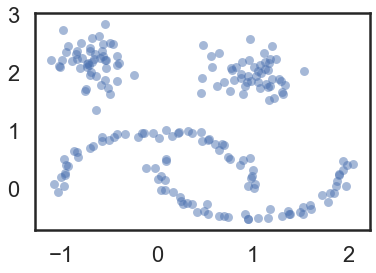

In [52]:
moons, _ = data.make_moons(n_samples = 100, 
                           noise = 0.05, 
                           random_state = 1234
                          )
blobs, _ = data.make_blobs(n_samples = 100, 
                           centers = [(-0.75, 2.25), 
                                      (1.0, 2.0)], 
                           cluster_std = 0.25, 
                           random_state = 1234
                          )
test_data = np.vstack([moons, 
                       blobs]
                     )
plt.scatter(test_data.T[0], 
            test_data.T[1], 
            color = 'b', 
            **plot_kwds
           );

#### Se necessário, a biblioteca [`hdbscan`](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html)  poderá ser instalada.

In [53]:
#!pip3 install hdbscan  --user

#### Realizamos a clusterização com o método [`hdbscan.HDBSCAN()`](https://hdbscan.readthedocs.io/en/latest/basic_hdbscan.html).

In [71]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size = 5, 
                            gen_min_span_tree = True
                           )
clusterer.fit(test_data)

HDBSCAN(gen_min_span_tree=True)

#### Para que a clusterização acima ocorra, temos 5 passos a percorrer:

1. Realizar a transformação de Transformar o espaço para um espaço de densidade;
2. Criar uma árvore de relações de pontos nesse novo espaço;
3. Construir uma [hierarquia](https://www.kdnuggets.com/2019/09/hierarchical-clustering.html) entre os nodos da árvore, com datapoints $2$ a $2$;
4. Condensar a [hierarquia](https://www.analyticsvidhya.com/blog/2019/05/beginners-guide-hierarchical-clustering/) do cluster de modo a minimizar o número de clusters;
5. Extrair os clusters da [hierarquia](https://towardsdatascience.com/tagged/hierarchical-clustering).

#### Step $1 + 2$: Transformação do espaço e criação da árvore.

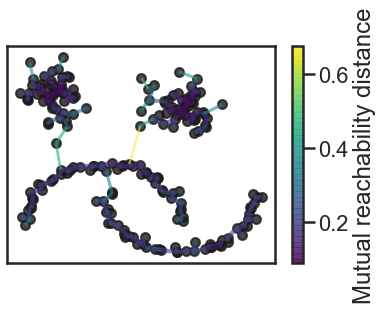

In [55]:
clusterer.minimum_spanning_tree_.plot(edge_cmap = 'viridis', 
                                      edge_alpha = 0.6, 
                                      node_size = 80, 
                                      edge_linewidth = 2
                                     );

#### Step 3: Hierarquia de pontos $2$ a $2$.

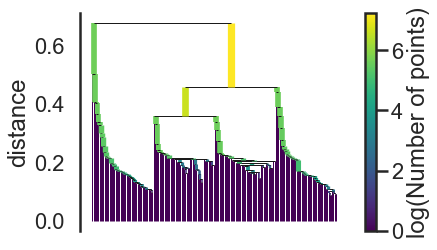

In [56]:
clusterer.single_linkage_tree_.plot(cmap = 'viridis', 
                                    colorbar = True
                                   );

#### Step $4$: Condensando a [hierarquia](https://towardsdatascience.com/understanding-the-concept-of-hierarchical-clustering-technique-c6e8243758ec) acima em `clusters`.

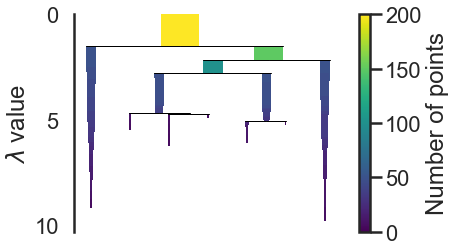

In [57]:
clusterer.condensed_tree_.plot();

#### Step $5$: Extrair os `clusters`.

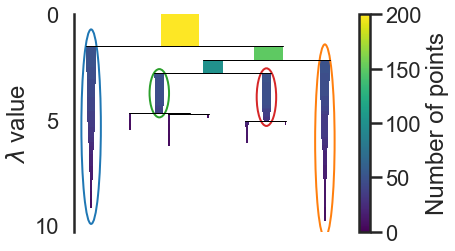

In [58]:
clusterer.condensed_tree_.plot(select_clusters = True, 
                               selection_palette = sns.color_palette()
                              );

#### Plotamos dos resultados.

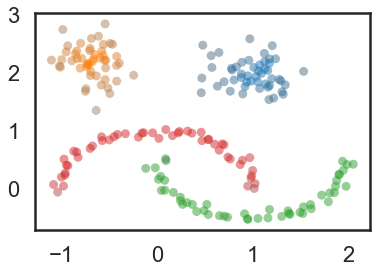

In [59]:
palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], 
                                 sat
                                ) 
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in 

                  zip(clusterer.labels_, 
                      clusterer.probabilities_)
                 ]
plt.scatter(test_data.T[0], 
            test_data.T[1], 
            c = cluster_colors, 
            **plot_kwds
           );

## Comparando HDBSCAN e outros métodos de clusterização

#### Vamos [comparar](https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html) alguns modelos de clusterização.

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import time
%matplotlib inline

sns.set_context('poster')

sns.set_color_codes()

plot_kwds = {'alpha' : 0.25, 
             's' : 80, 
             'linewidths': 0
            }

In [77]:
data = np.load('clusterable_data.npy')

#### Criamos uma dispersão dos pontos.

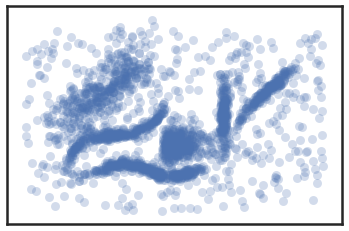

In [78]:
plt.scatter(data.T[0], 
            data.T[1], 
            c = 'b', 
            **plot_kwds
           )

frame = plt.gca()

frame.axes.get_xaxis().set_visible(False)

frame.axes.get_yaxis().set_visible(False)

#### E definimos uma função que plotar `clusters` de acordo com uma série de parâmentros, como o `dataset`, o método utilizado, e o número de `clusters`.

In [79]:
def plot_clusters(data, algorithm, args, kwds):

    start_time = time.time()
    
    labels = algorithm(*args, 
                       **kwds
                      ).fit_predict(data)
    
    end_time = time.time()
    
    palette = sns.color_palette('deep', 
                                np.unique(labels).max() + 1
                               )
    
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    
    plt.scatter(data.T[0], 
                data.T[1], 
                c = colors, 
                **plot_kwds
               )
    
    frame = plt.gca()
    
    frame.axes.get_xaxis().set_visible(False)
    
    frame.axes.get_yaxis().set_visible(False)
    
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), 
              fontsize = 24
             )
    
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), 
             fontsize = 14
            )

#### Método [`KMeans`](https://towardsdatascience.com/k-means-clustering-13430ff3461d), encontrar centros `k`, chamados de centróides de cluster, para cada um do número de `clasters` informado.

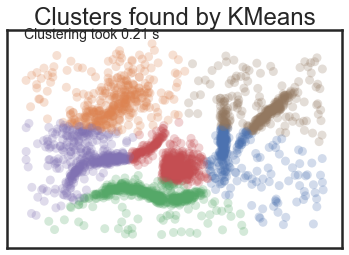

In [64]:
plot_clusters(data, 
              cluster.KMeans, 
              (), 
              {'n_clusters':6}
             )

#### Método [`AffinityPropagation`](https://towardsdatascience.com/math-and-intuition-behind-affinity-propagation-4ec5feae5b23), que não exige que você especifique o número `k` de clusters. Realiza cáclulos de matrizes de Similaridade, Responsabilidade, Avaleabilidade e Critério.

/Users/rudineycasali/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_affinity_propagation.py:152: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning)


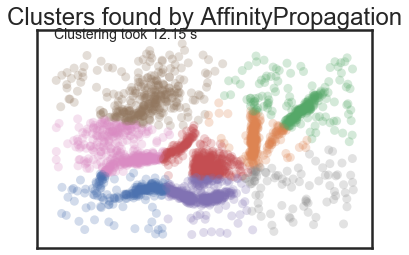

In [80]:
plot_clusters(data, 
              cluster.AffinityPropagation, 
              (), 
              {'preference': - 5.0, 'damping':0.95}
             )

#### Método [`MeanShift`](https://www.geeksforgeeks.org/ml-mean-shift-clustering/), que atribui os pontos aos `clusters`, de forma iterativa, mudando os pontos em direção à moda, em que moda é a densidade mais alta de pontos de dados na região.

/Users/rudineycasali/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass bandwidth=0.175 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


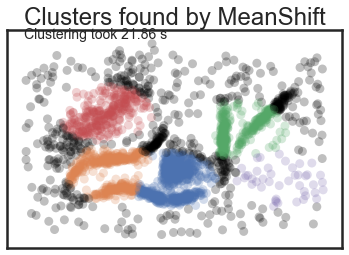

In [91]:
plot_clusters(data, 
              cluster.MeanShift, 
              (0.175,), 
              {'cluster_all':False}
             )

#### Método [`SpectralClustering`](https://www.mygreatlearning.com/blog/introduction-to-spectral-clustering/), que é uma técnica de EDA que reduz conjuntos de dados multidimensionais complexos em `clusters` de dados semelhantes em dimensões mais raras. O esboço principal é agrupar todo o espectro de pontos de dados não organizados em vários grupos com base em sua singularidade.

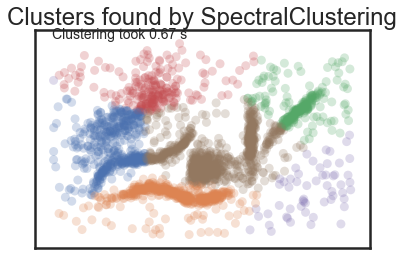

In [93]:
plot_clusters(data, 
              cluster.SpectralClustering, 
              (), 
              {'n_clusters': 6}
             );

#### Método [`AgglomerativeClustering`](https://www.datanovia.com/en/lessons/agglomerative-hierarchical-clustering/), que começa tratando cada objeto como um `cluster` `singleton`. Em seguida, pares de `clusters` são mesclados sucessivamente até que todos os `clusters` tenham sido mesclados em um grande cluster contendo todos os objetos.

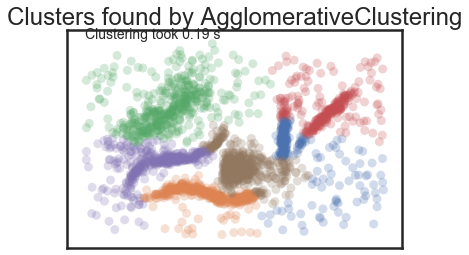

In [95]:
plot_clusters(data, 
              cluster.AgglomerativeClustering, 
              (), 
              {'n_clusters': 6, 'linkage': 'ward'}
             )

#### Método [`DBSCAN`](https://towardsdatascience.com/dbscan-clustering-explained-97556a2ad556#:~:text=DBSCAN%20stands%20for%20density%2Dbased,many%20points%20from%20that%20cluster.), que é um algoritmo não paramétrico de agrupamento, baseado em densidade. Dado um conjunto de pontos em algum espaço, ele agrupa pontos separando `clusters` de alta densidade de clusters de baixa densidade.

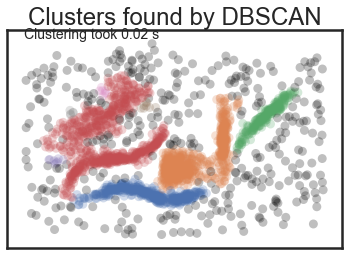

In [98]:
plot_clusters(data, 
              cluster.DBSCAN, 
              (), 
              {'eps': 0.025}
             )

#### Método `HDBSCAN`, estende o DBSCAN convertendo-o em um algoritmo de clustering hierárquico.

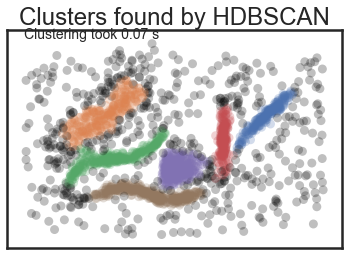

In [97]:
plot_clusters(data, 
              hdbscan.HDBSCAN, 
              (), 
              {'min_cluster_size': 15}
             )

#### Pelos resultados acima, conseguimos percerber a facilidade de `fitting` do `HDBSCAN` em relação a outros métodos de classificação.